<h1>Customer Personality Analysis - Dimensionality Reduction and Customer Segmentation</h1>
<h2>Table of Contents</h2>

* [Problem Statement](#1)
    
* [Project Objectives](#2)
    
* [Importing Libraries and Read In Dataset](#3)
    
* [Dimensionality Reduction](#4)   
    
* [Clustering Customers](#5) 
      
* [About the Clusters](#6)

* [Conclusions](#7)

<a id="1"></a>
<h2>Problem Statement</h2>
<p>
    Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.
</p>
<p>
    Source: <a href="https://www.kaggle.com/imakash3011/customer-personality-analysis">Kaggle - Customer Personality Analysis</a></p>

<a id="2"></a>
<h2>Project Objectives</h2>
<ol>
    <li>Determine customer traits and behaviors</li>
    <li>Group similar customers based on traits and behaviors</li>
    <li>Create predictive model to predict which customers will respond to marketting campaigns</li>
</ol>
<h5>In this notebook I will focus on the 2nd objective. I will read in the new cleaned dataset from the previous notebook
    (1.Feat_Eng_EDA.ipynb). Then, I will reduce the dimensionality of the dataset and cluster customers into different 
groups. Finally, I will describe some common attributes of each group and present my conclusions.</h5>

<a id="3"></a>
<h2>Importing Libraries and Read In Dataset</h2>

In [1]:
#Import Libraries
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data viz
import seaborn as sns #data viz
from sklearn.preprocessing import StandardScaler, OneHotEncoder #preprocessing
from sklearn.compose import ColumnTransformer #preprocessing
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.cluster import DBSCAN #clustering

In [2]:
#Read in previously cleaned dataset
pd.set_option('display.max_columns', None)
clean_data = pd.read_csv('data/mc_fe.csv', index_col='ID')
clean_data.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Days_Since_Customer,Fam_Size,Num_Accepted,MntTotal
ID,,,,,,,,,,,,,,,,,,,,,
5524,Graduation,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,64,3509.686794,1,0,2252
2174,Graduation,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,67,2663.686794,3,0,38
4141,Graduation,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,56,3010.686794,2,0,1202
6182,Graduation,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,37,2603.686794,3,0,64
5324,PhD,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,40,2859.686794,3,0,595


<h5>The data will need some preprocessing before the dimensionality is reduced. 'Education' needs to be encoded and the other
    columns need to be scaled. Also, the target column 'Repsonse' needs to be removed from the dataset.</h5>

In [3]:
#Remove the 'Response' column because it is the target of future predictive model
X, y = clean_data.drop('Response', axis=1).values, clean_data['Response'].values

#Creates a column transformer that sends 'Education' to be encoded and rest scaled
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), [0]),
    ('numeric', StandardScaler(), list(range(1, len(X.T))))
])

#Sends the data through the column transformer
X_transformed = ct.fit_transform(X)
print('Preprocessed Data:')
print(X_transformed[0])

Preprocessed Data:
[ 0.          0.          1.          0.          0.          0.23532677
  0.30703926  0.98378127  1.55157698  1.67970233  2.46214705  1.4765001
  0.84320691  0.34941394  1.40930394  2.51089024 -0.55078479  0.69390374
 -0.09728167  0.98534473  1.97674456 -1.75911463 -0.43903713  1.4669731 ]


<a id="4"></a>
<h2>Dimensionality Reduction</h2>

In [4]:
#Create instance of Principal Component Analysis in order to reduce dimensionality while maintaining variance
#n_components=3 will be chosen in order to visualize the data better
pca = PCA(n_components=3)

#fit to dataset
pca.fit(X_transformed)

#create dimentionality reduced dataset
X_reduced = pca.transform(X_transformed)

print('Dimentionality Reduced Data:')
print(X_reduced[0])

Dimentionality Reduced Data:
[ 4.19629069  1.01652754 -2.28229244]


<h5>The reduced dimentionality dataset now has only 3 dimensions. Let us take a look at the dataset now.</h5>

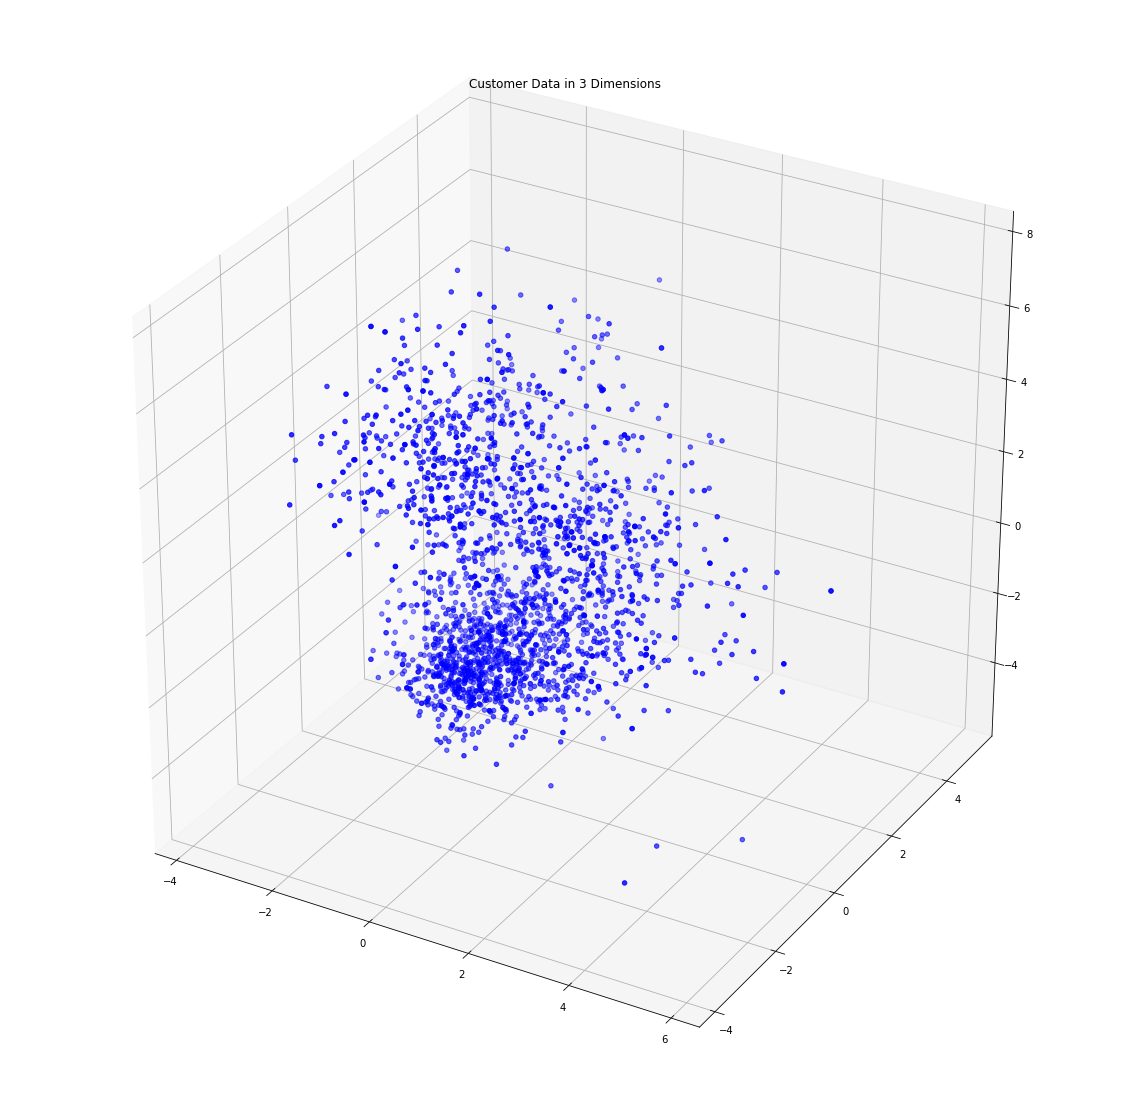

In [5]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c="blue")
ax.set_title("Customer Data in 3 Dimensions")
plt.show()

<h5>Now let us look at where 'Response' would fall in this distribution.</h5>

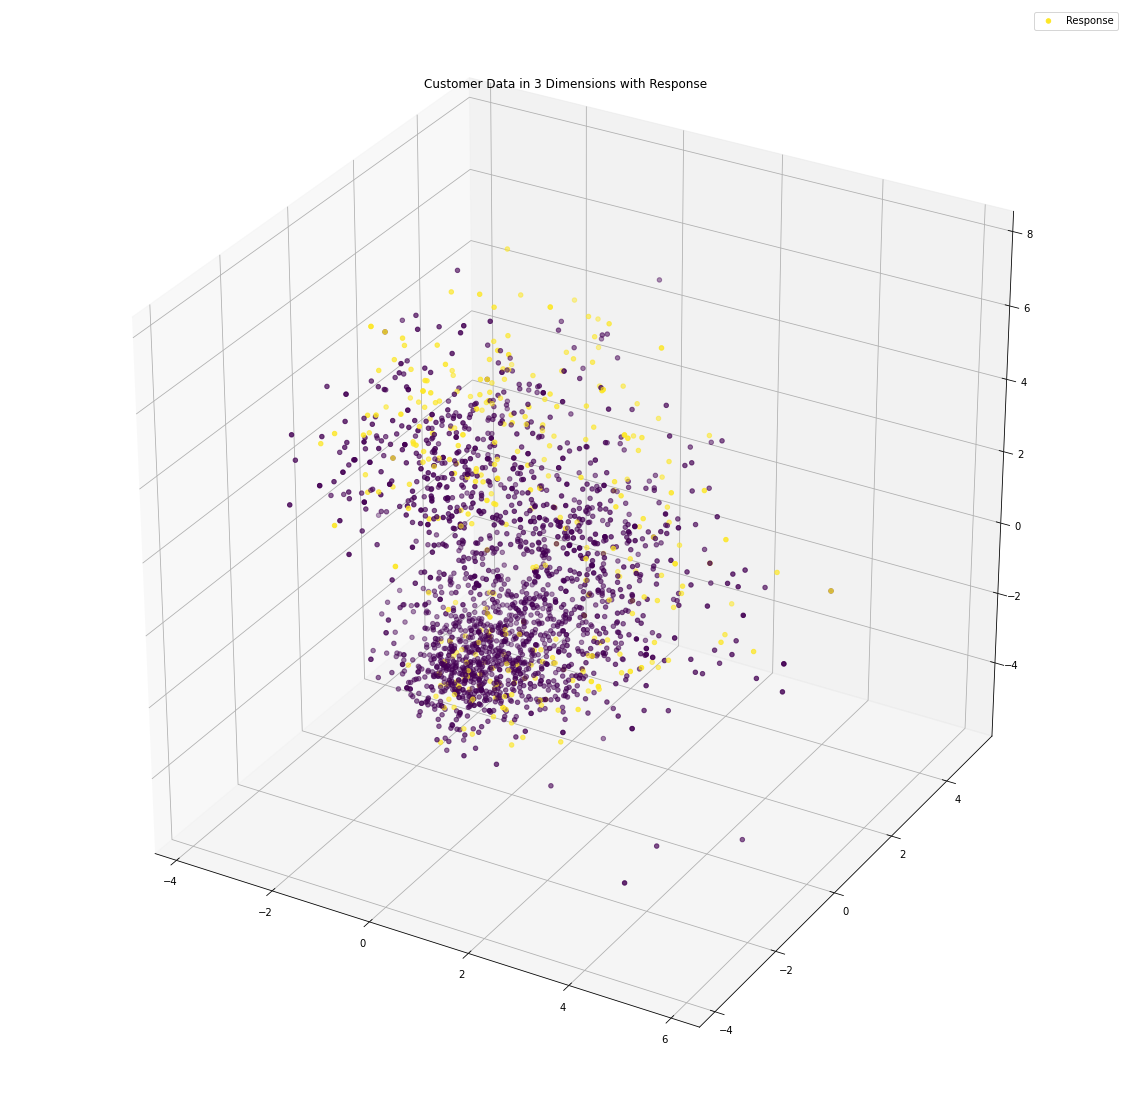

In [6]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c=y)
ax.set_title("Customer Data in 3 Dimensions with Response")
ax.legend(['Response'])
plt.show()

<h5>On initial inspection, it looks like many of the customers who responded were located outside of the dense cluster that holds most customers.</h5>

<a id="5"></a>
<h2>Clustering Customers</h2>

In [7]:
#Create an instance of DBSCAN to create non spherical clusters based on data density
db = DBSCAN(eps=0.726, min_samples=26)

#fit to the dimentionality reduced dataset
db.fit(X_reduced)

#identify the clusters
clusters = db.labels_

#display metrics/sample
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Cluster Predictions')
print('-------------------------------')
print("Number of clusters: %d" % n_clusters_)
print("Number of noise points: %d" % n_noise_)
print('Number of points per cluster:')
for i in range(n_clusters_):
    print('Cluster', i, ':', len(clusters[clusters==i]))

Cluster Predictions
-------------------------------
Number of clusters: 3
Number of noise points: 756
Number of points per cluster:
Cluster 0 : 1286
Cluster 1 : 29
Cluster 2 : 169


<h5>Now there are 3 distinct clusters of customers along with 749 outlier customers.</3>

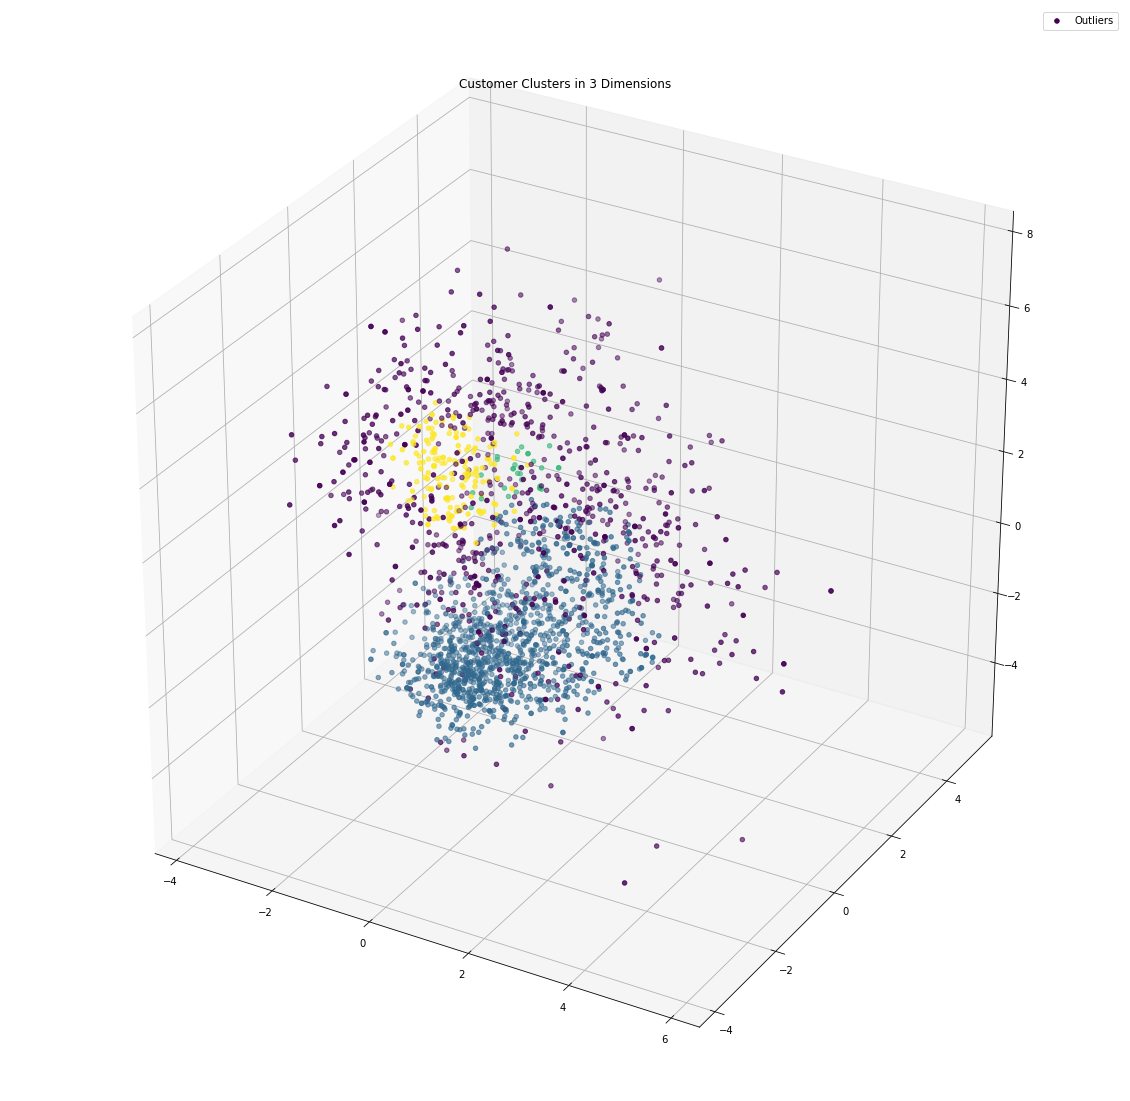

In [8]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], 
           c=clusters)
ax.set_title("Customer Clusters in 3 Dimensions")
ax.legend(['Outliers'])
plt.show()

<a id="6"></a>
<h2>About the Clusters</h2>

In [9]:
#append the clusters to the original dataset
clean_data['Cluster'] = clusters

#group by cluster and calculate how many responses there were per cluster
cluster_grp = clean_data.groupby('Cluster').Response.agg(['sum', 'count'])
cluster_grp['percent_resp'] = cluster_grp['sum'].values / cluster_grp['count'].values
cluster_grp

,sum,count,percent_resp
Cluster,,,
-1,177,756,0.234127
0,118,1286,0.091757
1,6,29,0.206897
2,33,169,0.195266


<h5>The outlier customers (-1) have a majority of those customers who responded to the campaign (176). On the other hand, customers of the biggest cluster (0) had only 9% response rate.</h5>

In [10]:
#create new dataframes for each cluster
outlier = clean_data[clean_data.Cluster == -1]
clus0 = clean_data[clean_data.Cluster == 0]
clus1 = clean_data[clean_data.Cluster == 1]
clus2 = clean_data[clean_data.Cluster == 2]

<h5>Let us compare the statistics of each cluster by plotting a few variables.</h5>

In [11]:
#Create function for plotting distributions per cluster
def create_kdeplot(col, title):
    plt.figure(figsize=(12,8))
    sns.kdeplot(data=outlier, x=col, label='Outliers')
    sns.kdeplot(data=clus0, x=col, label ='Cluster 0')
    sns.kdeplot(data=clus1, x=col, label ='Cluster 1')
    sns.kdeplot(data=clus2, x=col, label ='Cluster 2')
    plt.title(title)
    plt.legend()
    plt.show()
    
#Create function for plotting count of discrete values per cluster
def create_barplot(col, title):
    plt.figure(figsize=(8,8))
    sns.countplot(x=clean_data[col], hue=clean_data["Cluster"])
    plt.title(title)
    plt.legend(['Outliers', 'Cluster 0', 'Cluster 1', 'Cluster 2'])
    plt.show()

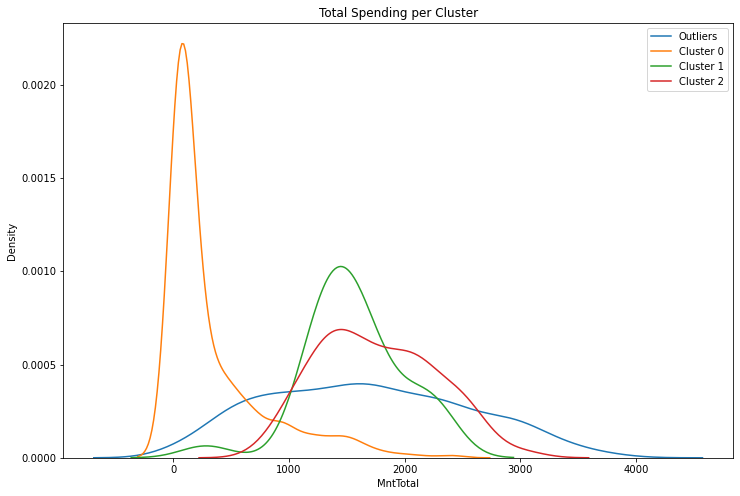

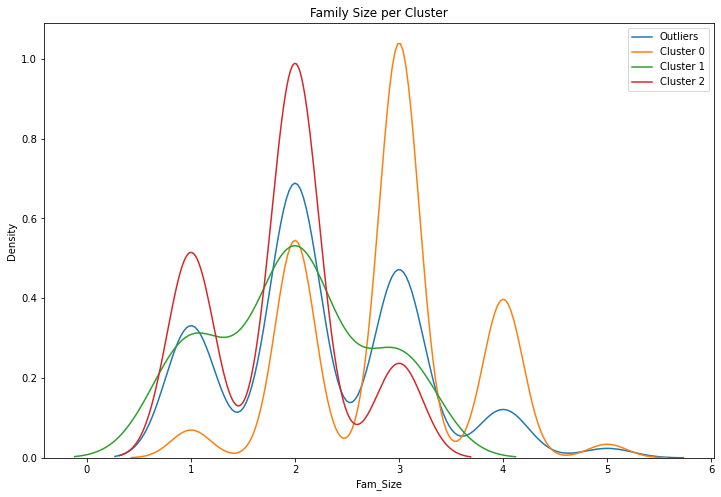

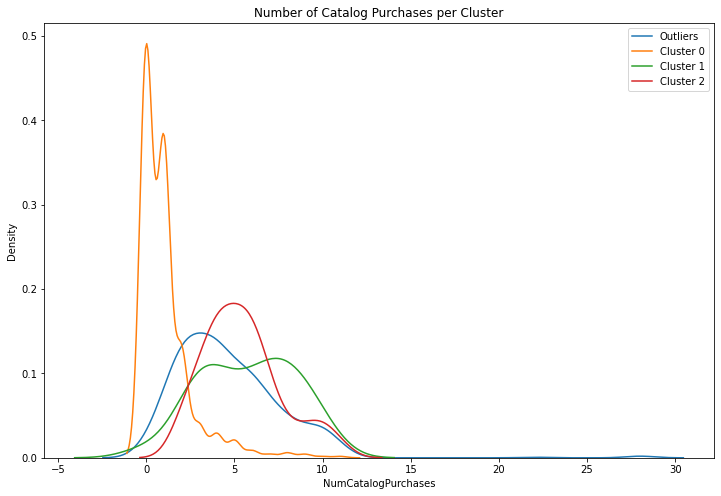

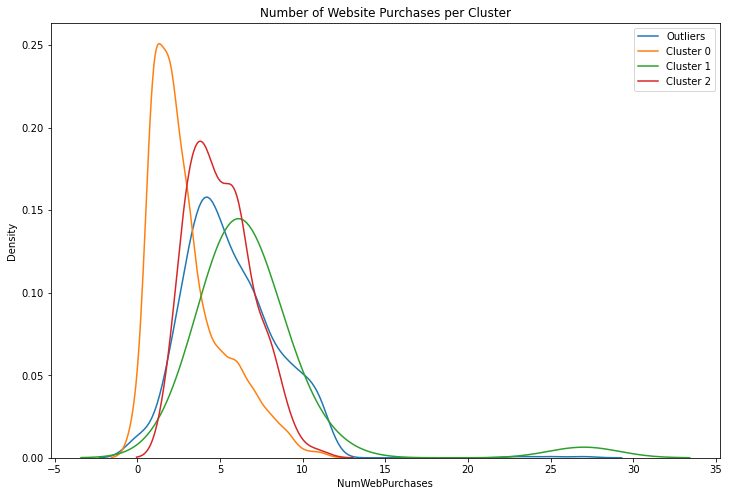

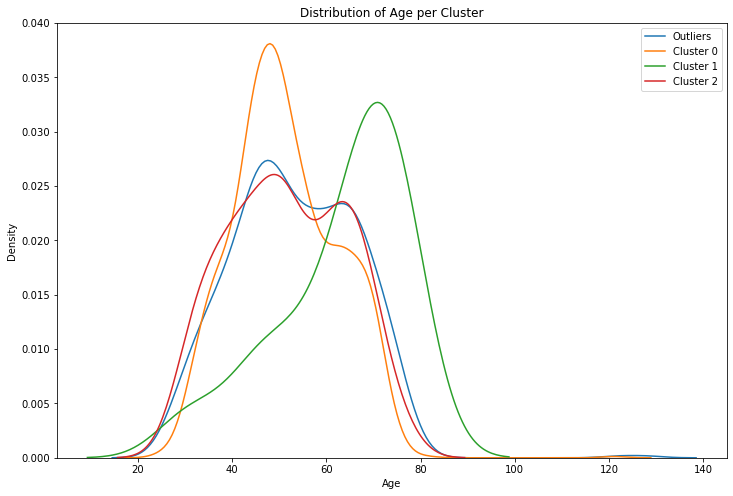

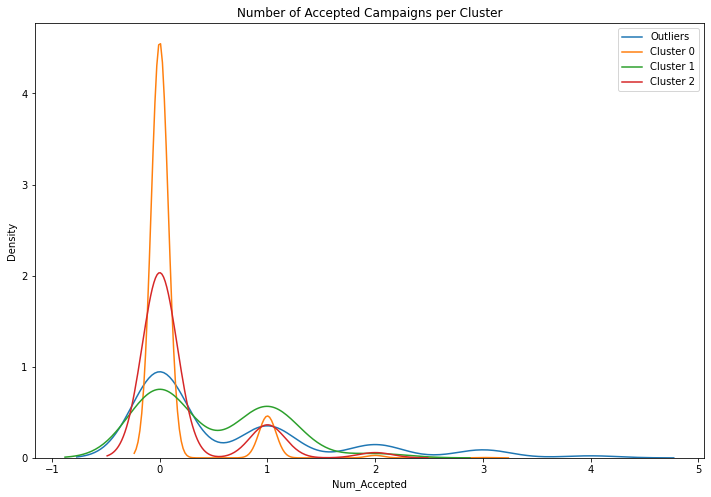

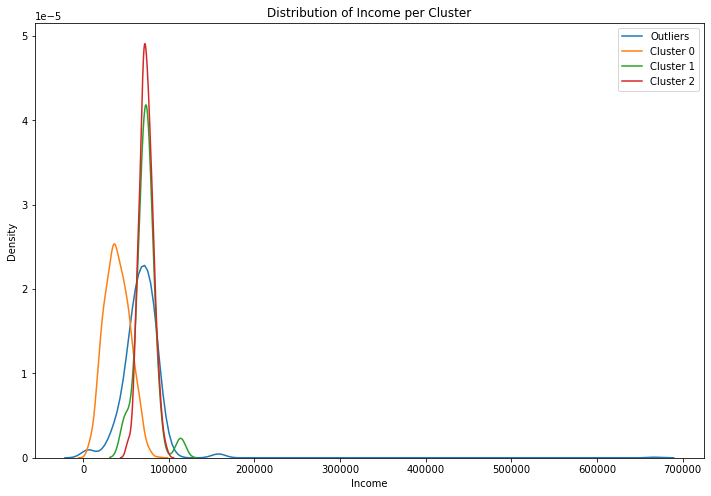

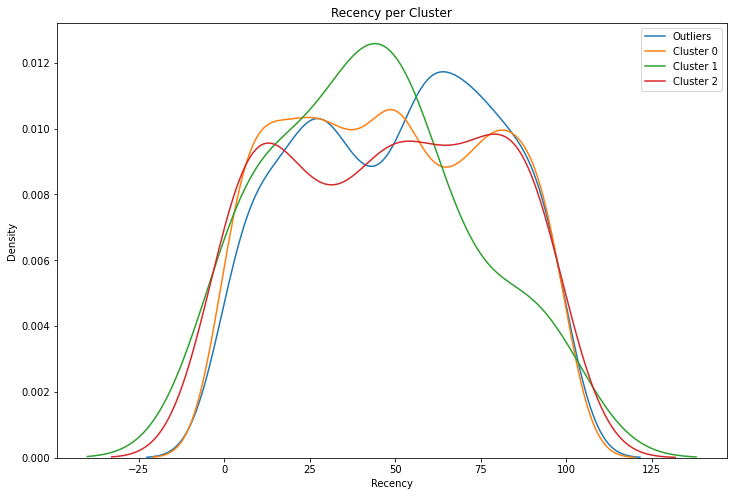

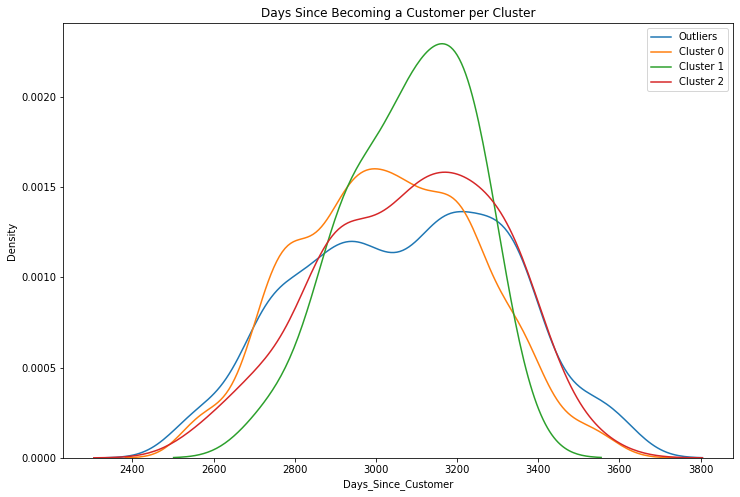

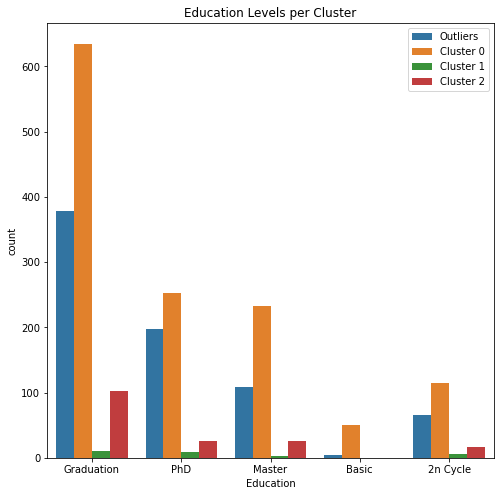

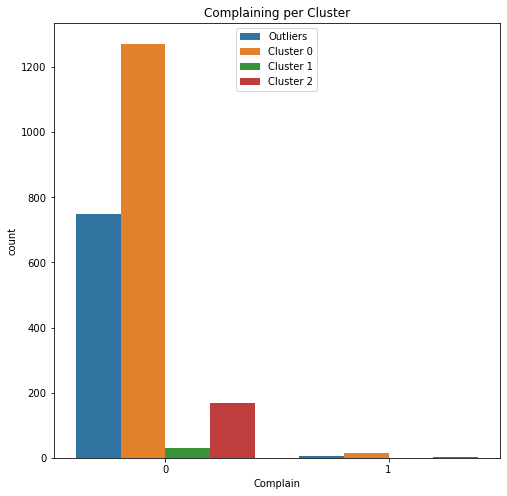

In [12]:
#Create list of variables to plot distributions
vars_to_kdeplot = [('MntTotal', 'Total Spending per Cluster'),
                ('Fam_Size', 'Family Size per Cluster'),
                ('NumCatalogPurchases', 'Number of Catalog Purchases per Cluster'),
                ('NumWebPurchases', 'Number of Website Purchases per Cluster'),
                ('Age', 'Distribution of Age per Cluster'),
                ('Num_Accepted', 'Number of Accepted Campaigns per Cluster'),
                ('Income', 'Distribution of Income per Cluster'),
                  ('Recency', 'Recency per Cluster'),
                  ('Days_Since_Customer', 'Days Since Becoming a Customer per Cluster')]

#Create list of variables to plot in bar graph
vars_to_barplot = [('Education', 'Education Levels per Cluster'),
                  ('Complain', 'Complaining per Cluster')]


#plot all kde plots
for var in vars_to_kdeplot:
    create_kdeplot(var[0], var[1])

#plot all bar plots
for var in vars_to_barplot:
    create_barplot(var[0], var[1])

<h5>There is quite a bit of variance between the largest cluster (cluster 0) and the other cluster. The other clusters and the outliers vary in more subltle ways. Below are some key points for each cluster</h5>

<h3>Cluster 0</h3>
<ul>
    <li>Low Spending</li>
    <li>Lower Income</li>
    <li>Larger Family</li>
    <li>Middle Aged</li>
    <li>Doesn't Respond to Marketing</li>
</ul>
<h3>Cluster 1</h3>
<ul>
    <li>Moderate Spending</li>
    <li>Smaller Family</li>
    <li>Retirement Age</li>
    <li>High Catalog and Web Purchases</li>
    <li>Long Time Customer</li>
    <li>Moderate Response to Marketing</li>
</ul>
<h3>Cluster 2</h3>
<ul>
    <li>High Spending</li>
    <li>Smaller Family</li>
    <li>Moderate Catalog and Web Purchases</li>
    <li>Early-Middle Aged</li>
    <li>Slight Response to Marketing</li>
</ul>
<h3>Outliers</h3>
<ul>
    <li>Variant Spending</li>
    <li>Medium-High Income</li>
    <li>Medium Sized Family</li>
    <li>Moderate Catalog and Web Purchases</li>
    <li>Middle Aged</li>
    <li>High Response to Marketing</li>
</ul>

<a id="7"></a>
<h2>Conclusions</h2>

<ul>
    <li><strong>The majority of customers are low spenders</strong> with big families and not likely to respond 
        to a campaign. This group of customers have lower incomes on average (compared to other customer groups)
    and probably do not have much money to spend on extra products. Marketing targeting this group will be difficult 
    due to these reasons.</li>
    <li><strong>Customers who deviate from the norm, are more likely to respond to marketing.</strong> Amoung
        these customers are 3 groups: moderately spending elderly customers, high spending middle aged customers, and
        outlier customers who tend to have higher incomes. Overall, these groups both make more and spend more money 
    than the majority of customers. Marketing targeting these groups have a higher chance of success. This could be
    accomplished using the web or catalogs.</li>
</ul>

<h5>Next, I will be performing prediction of response to marketing in the '3.Customer_Prediction' notebook</h5>